
# BCT Winter 2020
# November 4, 2020
# STATE-SPACE MODELS AND KALMAN FILTER

# FULL TREND-CYCLE WITH ESTIMATION



#### HOUSEKEEPING ####

In [1]:
rm(list = ls())
options(repr.plot.width = 10, repr.plot.height = 4)

#### DATA ####

In [2]:
library(readxl)
gdp   <- na.omit(read_excel("gdpCZ.xlsx"))
dates <- gdp$period
gdp   <- log(gdp$value)
gdpG  <- c(0,diff(gdp))

#### Prepare nice ggplot ####

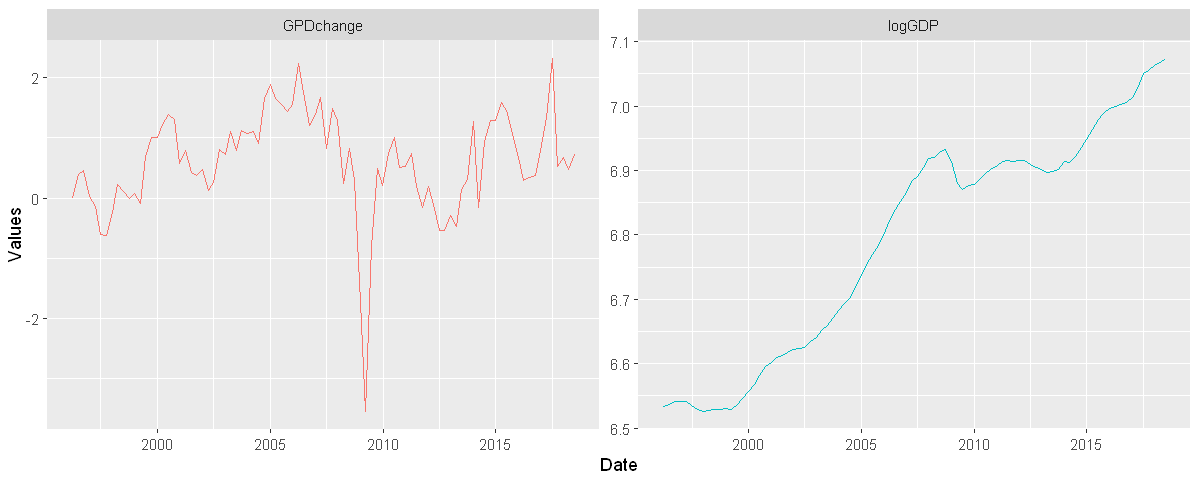

In [3]:
library(ggplot2)

data.plot = data.frame(Date = rep(dates,2),
                       Category = rep(c("logGDP","GPDchange"), each=length(gdp)),
                       Values = c(gdp,gdpG*100))

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                                                 geom_line(aes(color=Category)) + 
                                          facet_wrap(~ Category, scales='free')+ 
                                                    theme(legend.position="none")


# STORY
 some of the dynamics is driven by potential GDP, some by some cyclical fluctuations (GDP gap) we are interested in the potential, which is, however, unobservable consequently, we will try to estimate the potential as a state variable in the state-space model

## MACRO-MODELLING 

 SPACE of models --> model selection --> parameter estimation

 ARIMA models ... I have a small SPACE of possible models defined by the AR/MA/D orders the only structure imposed is that the residuals are white noise otherwise all is data-driven (ACF/PACF, residual diagnostics, ...)
                  
                  
 State space model ... infinitelly large structure of possible models the models are defined by the set of 




## MODEL:


### 1) MEASUREMENT EQUATION:  

   $y(t)   =     H       *    X(t)      + v(t);$ where   $v(t) \sim N(0,R)  $

   gpd    =  transformation of states  + measurement error                     
                                 
  $ y(t)   =  \begin{pmatrix} h1& h2& h3\end{pmatrix}*  \begin{pmatrix} TREND(t)\\CYCLE(t)\\CYCLE(t-1)\end{pmatrix}+ v(t);$ where  $v(t) \sim N(0,sigmaR)  $
                      


### 2) TRANSITION EQUATION:      

$X(t)    = A   + F*X(t-1) +u(t);$     where $u(t) \sim  N(0,Q)$

  $ \begin{pmatrix} TREND(t)\\CYCLE(t)\\CYCLE(t-1)\end{pmatrix}  = \begin{pmatrix} a1\\a2\\a3  \end{pmatrix} + \begin{pmatrix} f11 & f12 & f13 \\ f21 & f22& f23 \\ f21 & f22 & f33 \end{pmatrix} * \begin{pmatrix} TREND(t-1)  \\ CYCLE(t-1)  \\ CYCLE(t-2)  \end{pmatrix} + \begin{pmatrix} u1(t)\\ u2(t)  \\ u3(t)  \end{pmatrix} $
  
  $u(t) \sim N\bigg(0, \begin{pmatrix} sigmaQ1 & 0 & 0 \\ 0 & sigmaQ2& 0 \\ 0 & 0 & sigmaQ3\end{pmatrix}\bigg)$
  
  
     factors   =           some dynamic process              +               transition (state) error

### 3) RESTRICTIONS - to identify the model:

 if not, infinity of equivalent models exist:
 - states fluctuating around 1000 and H parameters of a degree 0.01
 - states fluctuating around  100 and H parameters of a degree 0.10
 - states fluctuating around   10 and H parameters of a degree 1.00
 - etc.
 
 => estimation would not converge!!
 
restrictions on measurement equation:
 - $ h1 = 1, h2 = 1, h3 = 0$
 - R is zero

restrictions on transition equation:
 - trend equation:      $  f11 = 1, f12 = f13 = 0 $
 - cycle equation:    $    f21 = 0$
 - lagged cycle identity: $f32 = 1, f31 = f33 = a3 = 0$
 - Q is diagonal

restriction on the relation $u$ and $v$:  $u(t)$ and $v(t)$ have zero covariance


### WRITING KALMAN RECURSION ####

#### 1) lets write down the final model:
 
$$y(t) = \begin{pmatrix} 1& 1& 0\end{pmatrix}*  \begin{pmatrix} TREND(t)\\CYCLE(t)\\CYCLE(t-1)\end{pmatrix}$$

 $$ \begin{pmatrix} TREND(t)\\CYCLE(t)\\CYCLE(t-1)\end{pmatrix}  = \begin{pmatrix} a1\\a2\\0  \end{pmatrix} + \begin{pmatrix} 1 & 0 & 0 \\ 0 & f22& f23 \\ 0 & 1 & 0 \end{pmatrix} * \begin{pmatrix} TREND(t-1)  \\ CYCLE(t-1)  \\ CYCLE(t-2)  \end{pmatrix} + \begin{pmatrix} u1(t)\\ u2(t)  \\ 0  \end{pmatrix} $$
  
   $$u(t) \sim N\bigg(0, \begin{pmatrix} sigmaQ1 & 0 & 0 \\ 0 & sigmaQ2& 0 \\ 0 & 0 & 0\end{pmatrix}\bigg)$$

#### 2) let's guess the initial values of missing parametes
we need to transform:
- $f22+f33$ to obtain stationary process
- sigmas to have positive variance

In [4]:
a1    = mean(diff(gdp)) 
a2    = 0

sigmaQ1 = log(sd(diff(gdp))^2) # will be transformed below
sigmaQ2 = log(sd(diff(gdp))^2) # will be transformed below

f22in   = 2 # will be transformed below
f23in   = 2 # will be transformed below

#### 3) save these parameters into single vector:

In [5]:
theta = c(a1, a2, sigmaQ1, sigmaQ2, f22in, f23in)

#### 4) call data

In [6]:
data = gdp
pers  <- length(data)

#### 5) now we need to get the model matrices

In [7]:
HH = matrix(c(1, 1, 0), ncol = 3)
AA = matrix(c(theta[1:2],0), ncol = 1)
RR = 0

# QQ transformed to have positive diagonal elements
QQ = diag(c(exp(theta[3:4]),0))

# FF matrix calculated from f22in and f23in by their
# transformation ensuring that AR(2) process is stationary
# ((note: three AR(2) stationarity conditions ensured by the
#   transformation are: f23+f22<1 , f23-f22<1 , |f23|<1 ))
f22ad = theta[5]/(1+abs(theta[5]))
f23ad = theta[6]/(1+abs(theta[6]))
f22 = f22ad + f23ad
f23 = -f22ad*f23ad
FF = matrix(c( 1, 0    , 0  ,
                        0, f22, f23,
                        0, 1   , 0    ), byrow = T, ncol = 3)

#### 6) initial conditions for states

In [8]:
X0 = c(data[1]-theta[1],0,0) # initial trend is equal to observed GDP and initial cycle is zero
P0 = 10*QQ      # initial variance of states set rather high

#### 7a) prepare empty matrices for states:

In [9]:
states0 = matrix(NA,nrow = pers, ncol = 3)
states1 = matrix(NA,nrow = pers, ncol = 3)

#### 7b) prepare empty array for state variances:

In [10]:
stVars0 = array(NA,dim = c(pers,3,3))
stVars1 = array(NA,dim = c(pers,3,3))

#### 8) go step-by-step through all periods and filter states:

In [11]:
for (tt in 1:pers){
  
  # predict GDP, based on the last known states
  X1pred = AA + FF%*%X0           # state prediction
  P1pred = FF%*%P0%*%t(FF) + QQ   # variance prediction
  YYpred = HH%*%X1pred            # GDP prediction
  
  states0[tt,] = X1pred
  stVars0[tt,,] = P1pred
  
  # calculate error of prediction
  YYerror = data[tt] - YYpred     # error
  
  # updating
  obsVAR = HH%*%P1pred%*%t(HH) + RR       # predicted variance of observations
  KG     = P1pred%*%t(HH)%*%solve(obsVAR) # Kalman Gain used to update states by error
  X1     = X1pred + KG%*%YYerror          # predicted stated updated by a part of the error
  P1     = P1pred - KG%*%HH%*%P1pred      # predicted state variance updated by the KG
  # high state variance P1pred => high Kalman Gain => observed error matters (sizeable updating)
  # high variance of observations obsVAR => low Kalman Gain => measured values not so important
  # => do I believe more my predictions of states of the measurements? what has higher varinace?
  
  # saving results
  states1[tt,] = X1
  stVars1[tt,,] = P1
  
  # going into the next loop
  X0 = X1
  P0 = P1
}

#### PLOTTING INITIAL RECURSION RESULTS 

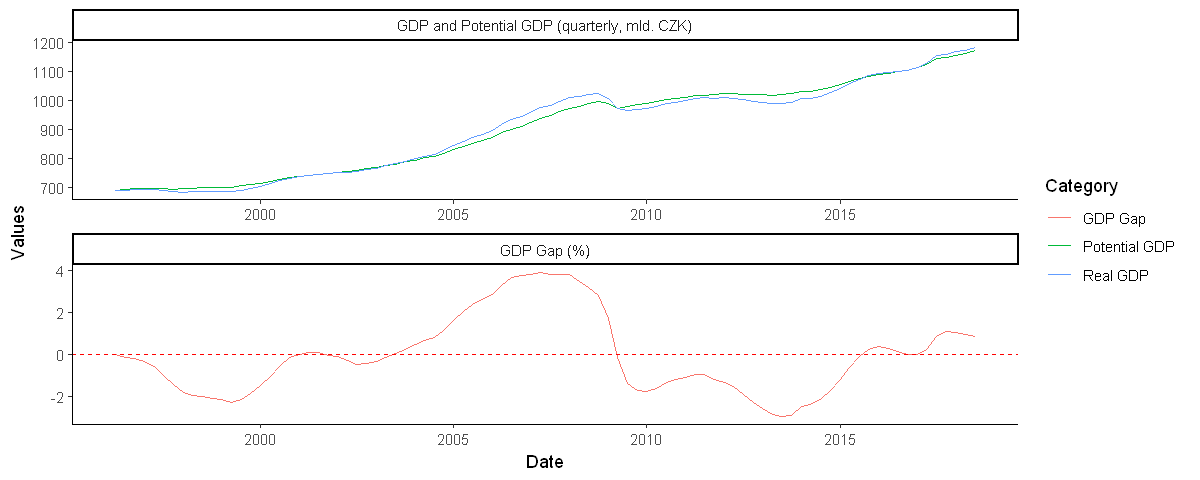

In [12]:
data.plot = data.frame(Date = rep(dates,3),
                       Category = rep(c("Real GDP","Potential GDP","GDP Gap"), each=pers),
                       Plottt = c(rep("GDP and Potential GDP (quarterly, mld. CZK)",2*pers),
                                  rep("GDP Gap (%)",pers)),
                       Values = c(exp(gdp),exp(states1[,1]),states1[,2]*100))
ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
  geom_line(aes(color=Category)) + 
  facet_wrap(~ Plottt, ncol = 1, scales='free') +
  theme_classic() + 
  geom_hline(aes(yintercept=int), data.frame(int=c(0),Plottt=c("GDP Gap (%)")), color="red",lty=2)

## PREPARE ESTIMATING 
the above is calculated for the "GUESSED" parameters only lets use the MLE to estimate the best parameter choice

    1] copy-paste the Kalman recursion from above
    2] wrap it as a function
    3] add the MLE calculation and the log-likelihood as the output
    4] optimize using nlm() function

### 1) DEFINE FUNCTION INCLUDING LIKELIHOOD

In [13]:
kalmanFUN <- function(theta, data, type){
  
  # 1) lets write down the final model:
  #                     |TREND(t)  |
  #   y(t)   =  [1 1] * |CYCLE(t)  | + v(t); v(t) ~ N(0,sigmaR)  
  #                     |CYCLE(t-1)|
  #
  # |TREND(t)  |     |a1|    |1  0   0 |     |TREND(t-1)|     |u1(t)|             |sigmaQ1 0 0|
  # |CYCLE(t)  |  =  |a2| +  |0 f22 f23|  *  |CYCLE(t-1)|  +  |u2(t)|; u(t) ~ N(0,|0 sigmaQ2 0|)  
  # |CYCLE(t-1)|     | 0|    |0  1   0 |     |CYCLE(t-2)|     |  0  |;            |0 0       0|  
  
  # number of periods
  pers  <- length(data)
  
  # get the model matrices
  HH = matrix(c(1, 1, 0), ncol = 3)
  AA = matrix(c(theta[1:2],0), ncol = 1)
  RR = 0
  QQ = diag(c(exp(theta[3:4]),0))
  
  f22ad = theta[5]/(1+abs(theta[5]))
  f23ad = theta[6]/(1+abs(theta[6]))
  f22 = f22ad + f23ad
  f23 = -f22ad*f23ad
  FF = matrix(c( 1 , 0 , 0 ,
                 0 ,f22,f23,
                 0 , 1 , 0),byrow = T, ncol = 3)
  
  # initial conditions for states
  X0 = c(data[1]-theta[1],0,0) # initial trend is equal to observed GDP and initial cycle is zero
  P0 = 10*QQ                # initial variance of states set rather high
  
  # prepare empty matrices for states:
  states0 = matrix(NA,nrow = pers, ncol = 3)
  states1 = matrix(NA,nrow = pers, ncol = 3)
  
  # 7b) prepare empty arrays for state variances:
  stVars0 = array(NA,dim = c(pers,3,3))
  stVars1 = array(NA,dim = c(pers,3,3))
  
  # set loglik to zero
  loglk = 0
 
  # go step-by-step through all periods:
  for (tt in 1:pers){
    
    # predict GDP, based on the last known states
    X1pred = AA + FF%*%X0           # state prediction
    P1pred = FF%*%P0%*%t(FF) + QQ   # variance prediction
    YYpred = HH%*%X1pred            # GDP prediction
    
    states0[tt,] = X1pred
    stVars0[tt,,] = P1pred
    
    # calculate error of prediction
    YYerror = data[tt] - YYpred        # error
    obsVAR = HH%*%P1pred%*%t(HH) + RR  # predicted variance of observations
    
    # loglik
    if (rcond(obsVAR) > 1e-10){
        loglk = loglk - 1/2*(
                            log(2*pi) +
                            log(det(obsVAR)) +
                            t(YYerror) %*% solve(obsVAR) %*% YYerror
                            )
    }else{ # avoid singularity
      loglk = loglk - 1e50
      break
    }
    
    # updating
    KG     = P1pred%*%t(HH)%*%solve(obsVAR) # Kalman Gain used to update states by error
    X1     = X1pred + KG%*%YYerror          # predicted stated updated by a part of the error
    P1     = P1pred - KG%*%HH%*%P1pred      # predicted state variance updated by the KG
    # high state variance P1pred => high Kalman Gain => observed error matters (sizeable updating)
    # high variance of observations obsVAR => low Kalman Gain => measured values not so important
    # => do I believe more my predictions of states of the measurements? what has higher varinace?
                          
    # saving results
    states1[tt,] = X1
    stVars1[tt,,] = P1
    
    # going into the next loop
    X0 = X1
    P0 = P1
  }
  
  # you need negative loglik, since the optimization function minimizes
  negLogLik = -loglk
  
  
  # determine whether the function returns LOGLIK (for optimization) or the resulting states)
  if (type == "MLE"){
    return(negLogLik) 
  } else {
    output = list()
    output$states0 = states0
    output$states1 = states1
    output$stVars0 = stVars0
    output$stVars1 = stVars1
    output$FF = FF
    return(output)
  }
}

In [14]:
library("MASS")
kalmanSMTH <- function(output){
  #FUNCTION FOR KALMAN SMOOTHER
  # input = output from kalmanFUN:
  #           states0, states1,
  #           stVars0, stsVars1,
  #           FF
  # note that since we use rather simple model, the convergence
  # may imply P matrix close to singular, which would result into
  # a collapse of the function solve() to get its inverse.
  # Therefore, you may need to use function ginv() from library MASS
  # to obtain the inverse, instead.
  
  states0 = output$states0
  states1 = output$states1
  stVars0 = output$stVars0
  stVars1 = output$stVars1
  
  FF = output$FF
  
  pers = dim(states0)[1]
  
  statesSmooth = matrix(NA,nrow = pers, ncol = 3)
  statesSmooth[pers,] = states1[pers,]
  stVarsSmooth = array(NA,dim = c(pers,3,3))
  stVarsSmooth[pers,,] = stVars1[pers,,]
  for (tt in seq(from = pers-1, to = 1, by = -1)){
    # missing part
  }
  return(statesSmooth)
}

### TEST THE FUNCTION FOR "GUESSED" THETA and plot both filtered and smoothed states

[,1]     
[1,] -294.2875

Warning message:
"Removed 178 rows containing missing values (geom_path)."

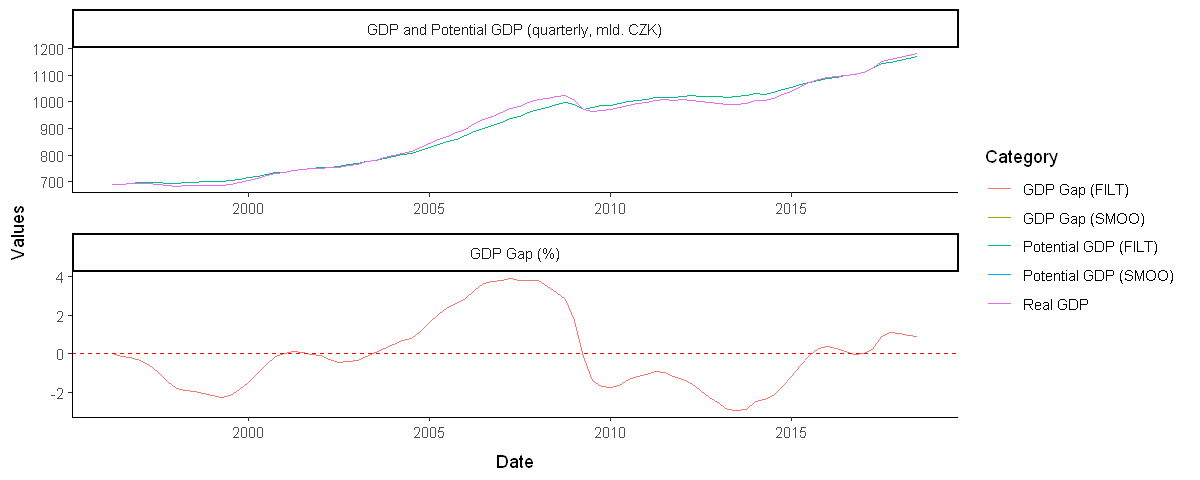

In [15]:
kalmanFUN(theta, gdp, "MLE")         # first type 
outInit <- kalmanFUN(theta, gdp, "X") # second type
statesF <- outInit$states1
statesS <- kalmanSMTH(outInit)

data.plot = data.frame(
  Date     = rep(dates,5),
  Category = rep(c("Real GDP",
                   "Potential GDP (FILT)","GDP Gap (FILT)",
                   "Potential GDP (SMOO)","GDP Gap (SMOO)"),each=pers),
  Plottt   = rep(c("GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)"),each=pers),
  Values = c(exp(gdp),
             exp(statesF[,1]),statesF[,2]*100,
             exp(statesS[,1]),statesS[,2]*100)
)
ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
  geom_line(aes(color=Category)) + 
  facet_wrap(~ Plottt, ncol = 1, scales='free') + theme_classic() + 
  geom_hline(aes(yintercept=int), data.frame(int=c(0),Plottt=c("GDP Gap (%)")), color="red",lty=2)

### ESTIMATE 

In [16]:
parOpt <- optim(theta, kalmanFUN, gr = NULL, gdp, "MLE", control = list(trace = 3, maxit = 5000), 
                method = "Nelder-Mead")
# method = c("Nelder-Mead", "BFGS", "CG", "L-BFGS-B", "SANN","Brent")

thetaO = parOpt$par

#print(theta)
#print(thetaO)

outFin <- kalmanFUN(thetaO, gdp, "X") # second type
statesFinF <- outFin$states1
statesFinS <- kalmanSMTH(outFin)
  


  Nelder-Mead direct search function minimizer
function value for initial parameters = -294.287463
  Scaled convergence tolerance is 4.38522e-06
Stepsize computed as 0.955058
BUILD              7 504783.476907 -295.825536
LO-REDUCTION       9 89816.682249 -295.825536
HI-REDUCTION      11 25428.814429 -295.825536
HI-REDUCTION      13 22444.233309 -295.825536
HI-REDUCTION      15 5995.743535 -295.825536
LO-REDUCTION      17 5526.159151 -295.825536
LO-REDUCTION      19 1426.196360 -295.825536
HI-REDUCTION      21 892.029429 -295.825536
HI-REDUCTION      23 120.581639 -295.825536
HI-REDUCTION      25 0.654661 -295.825536
HI-REDUCTION      27 -189.721632 -295.825536
HI-REDUCTION      29 -218.200792 -295.825536
HI-REDUCTION      31 -266.032180 -295.825536
HI-REDUCTION      33 -272.935818 -295.825536
HI-REDUCTION      35 -275.516548 -295.825536
REFLECTION        37 -275.957024 -296.365392
REFLECTION        39 -284.918701 -301.595003
LO-REDUCTION      41 -286.423965 -301.595003
REFLECTION     

Warning message:
"Removed 178 rows containing missing values (geom_path)."

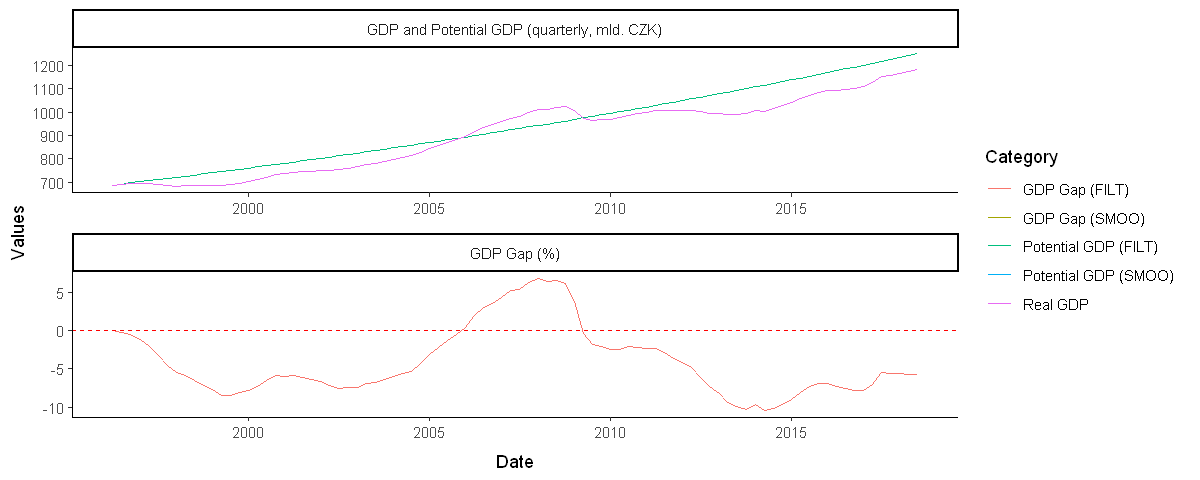

In [17]:
data.plot = data.frame(
  Date     = rep(dates,5),
  Category = rep(c("Real GDP",
                   "Potential GDP (FILT)","GDP Gap (FILT)",
                   "Potential GDP (SMOO)","GDP Gap (SMOO)"),each=pers),
  Plottt   = rep(c("GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)"),each=pers),
  Values = c(exp(gdp),
             exp(statesFinF[,1]),statesFinF[,2]*100,
             exp(statesFinS[,1]),statesFinS[,2]*100)
)
ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
  geom_line(aes(color=Category)) + 
  facet_wrap(~ Plottt, ncol = 1, scales='free') + theme_classic() + 
  geom_hline(aes(yintercept=int), data.frame(int=c(0),Plottt=c("GDP Gap (%)")), color="red",lty=2)

## FINAL PARAMETERS 

In [18]:
HH = matrix(c(1, 1, 0), ncol = 3)
AA = matrix(c(thetaO[1:2],0), ncol = 1)
RR = 0
QQ = diag(c(exp(thetaO[3:4]),0))

f22ad = thetaO[5]/(1+abs(thetaO[5]))
f23ad = thetaO[6]/(1+abs(thetaO[6]))
f22 = f22ad + f23ad
f23 = -f22ad*f23ad
FF = matrix(c( 1 , 0 , 0 ,
               0 ,f22,f23,
               0 , 1 , 0),byrow = T, ncol = 3)